In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
url = '/content/drive/MyDrive/CSE4238/'

## Dataset Proprosecing

In [4]:
dataset_C = url + 'Dataset C.zip'
with ZipFile(dataset_C, 'r') as zip:
  zip.extractall()

In [5]:
df = pd.read_csv('/content/training-c.csv',delimiter=None)
dfnew = df.drop(['original filename','scanid','database name original','contributing team','database name'],axis=1)
print(dfnew.shape)
dfnew.head()

(24298, 2)


,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [9]:
TRAIN_PATH = url + 'Train dataset'
os.mkdir(TRAIN_PATH)

In [10]:
PATH = '/content/'
def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-c')

In [12]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [13]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(dfnew, TRAIN_PATH, train_transform)
test_data = Dataset(dfnew, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))
print("Trainig Samples: ", len(test_data))

Trainig Samples:  24298
Trainig Samples:  24298


## Base HyperParam

In [ ]:
batch_size = 20
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

16


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:972
Test dataloader:243


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 2.298591136932373. Accuracy: 9.734513274336283
Epoch:  2
Iteration: 1000. Loss: 2.3032474517822266. Accuracy: 9.30232558139535
Iteration: 1500. Loss: 2.2991976737976074. Accuracy: 10.043218769294093
Epoch:  3
Iteration: 2000. Loss: 2.303338050842285. Accuracy: 9.878575838649928
Iteration: 2500. Loss: 2.3052589893341064. Accuracy: 9.878575838649928
Epoch:  4
Iteration: 3000. Loss: 2.30305552482605. Accuracy: 9.878575838649928
Iteration: 3500. Loss: 2.3037095069885254. Accuracy: 9.878575838649928
Epoch:  5
Iteration: 4000. Loss: 2.3057546615600586. Accuracy: 9.878575838649928
Iteration: 4500. Loss: 2.3056607246398926. Accuracy: 9.878575838649928
Epoch:  6
Iteration: 5000. Loss: 2.3008103370666504. Accuracy: 9.857995472319407
Iteration: 5500. Loss: 2.305354118347168. Accuracy: 10.002058036633052
Epoch:  7
Iteration: 6000. Loss: 2.3009376525878906. Accuracy: 9.30232558139535
Iteration: 6500. Loss: 2.303701639175415. Accuracy: 10.002058036633052
Epoch:  8
Ite

[2.298591136932373, 2.3032474517822266, 2.2991976737976074, 2.303338050842285, 2.3052589893341064, 2.30305552482605, 2.3037095069885254, 2.3057546615600586, 2.3056607246398926, 2.3008103370666504, 2.305354118347168, 2.3009376525878906, 2.303701639175415, 2.3052144050598145, 2.299736976623535, 2.3042500019073486, 2.3021738529205322, 2.2997477054595947, 2.3017382621765137, 2.307343006134033, 2.305562734603882, 2.2981977462768555, 2.3020451068878174, 2.296259641647339, 2.3026347160339355, 2.294309139251709, 2.30305814743042, 2.2993693351745605, 2.2995734214782715, 2.3083550930023193, 2.3008909225463867]


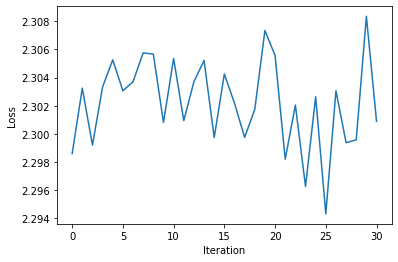

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()